In [1]:
import pandas as pd
import autograd.numpy as np
from autograd import grad 
import matplotlib.pyplot as plt
from common import gradient_descent, plot_cost_histories

In [2]:
# Read data
DATA_BASE_URL = "https://raw.githubusercontent.com/sql-injection/spotify_data/master/"
datasets = {
    "train": DATA_BASE_URL + "train.csv",
    "test": DATA_BASE_URL + "test.csv",
    "all": DATA_BASE_URL + "spotify.csv"
}

total_df = pd.read_csv(datasets["all"])
attribute_names = list(total_df)[:-1]
x = total_df[attribute_names].values
y = total_df["Class"].values

original_x = np.copy(x)
original_y = np.copy(y)

In [3]:
genre_histograms = {
    "edm":       np.asarray([1, 0, 0, 0, 0, 0, 0]),
    "hiphop":    np.asarray([0, 1, 0, 0, 0, 0, 0]),
    "classical": np.asarray([0, 0, 1, 0, 0, 0, 0]),
    "jazz":      np.asarray([0, 0, 0, 1, 0, 0, 0]),
    "pop":       np.asarray([0, 0, 0, 0, 1, 0, 0]),
    "country":   np.asarray([0, 0, 0, 0, 0, 1, 0]),
    "rock":      np.asarray([0, 0, 0, 0, 0, 0, 1])
}

In [4]:
# Genre encoded into one-hot vectors
y_encoded = np.array([genre_histograms[genre] for genre in y])

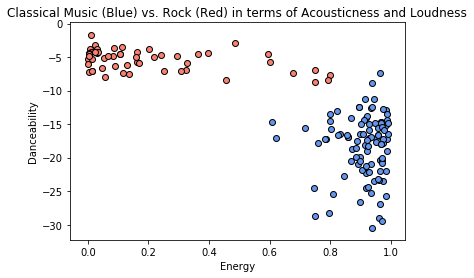

In [17]:
feature_a_indices =  np.where(y == "jazz")[0]
feature_b_indices = np.where(y == "country")[0]
feature_a_color = "cornflowerblue";
feature_b_color = "salmon";

attribute_names = np.array(attribute_names)
energy_attribute_index = np.where(attribute_names == "acousticness")[0][0]
danceability_attribute_index = np.where(attribute_names == "loudness")[0][0]

f = plt.figure()
ax = plt.subplot()
ax.set_xlabel("Energy")
ax.set_ylabel("Danceability")
ax.set_title("Classical Music (Blue) vs. Rock (Red) in terms of Acousticness and Loudness")
for i in feature_a_indices:
    ax.scatter(original_x[i, energy_attribute_index],
               original_x[i, danceability_attribute_index],
               color=feature_a_color, edgecolor='k')
    
for i in feature_b_indices:
    ax.scatter(original_x[i, energy_attribute_index],
               original_x[i, danceability_attribute_index],
               color=feature_b_color, edgecolor='k')
plt.show()